# Dataset

In [17]:
import pyreadstat
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.animation import FuncAnimation, PillowWriter
from functools import partial
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import umap.umap_ as umap 

/Users/olgashtykina/Desktop/Maths_in_ML/lab4/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def readMult(path = 'dataset.sav', labell='label', filter=True, type='sav'):
    dataset, meta = pyreadstat.read_sav('dataset.sav')
    required_columns = ['yj1.1.1', 'yj13.2', 'yj72.18a', 'yj6.2', 'yj10.2', 'yj21b']
    dataset = dataset[required_columns]
    dataset = dataset.rename(columns={
        'yj1.1.1': 'label',
        'yj13.2': 'salary',
        'yj72.18a': 'education',
        'yj6.2': 'working_hours',
        'yj10.2': 'bonus',
        'yj21b': 'vacation_days'
    })
    dataset = dataset.dropna()
    dataset = dataset[(dataset <= 1000000).all(axis=1)]
    dataset = dataset.astype(float)
    label = dataset['label'].astype(int)
    dataset = dataset.drop(columns=['label'])
    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.3, shuffle=False)
    main_X_test = X_test
    main_y_test = y_test - 1

    if type == 'sav':
        dataset, meta = pyreadstat.read_sav(path)
    else:
        dataset = pd.read_csv(path)
    if filter:
        required_columns = ['yj1.1.1', 'yj13.2', 'yj72.18a', 'yj6.2', 'yj10.2', 'yj21b']
        dataset = dataset[required_columns]
        dataset = dataset.rename(columns={
            'yj1.1.1': 'label',
            'yj13.2': 'salary',
            'yj72.18a': 'education',
            'yj6.2': 'working_hours',
            'yj10.2': 'bonus',
            'yj21b': 'vacation_days'
        })
    dataset = dataset.dropna()
    dataset = dataset[(dataset <= 1000000).all(axis=1)]
    dataset = dataset.astype(float)
    label = dataset[labell].astype(int)
    dataset = dataset.drop(columns=[labell])

    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.3, shuffle=False)
    
    main_X_train = X_train
    main_y_train = y_train - 1
    return main_X_train, main_X_test, main_y_train, main_y_test

Считываем семплированный датасет, нормируем

In [6]:
dataset = pd.read_csv('data/df2.csv')
required_columns = ['yj1.1.1', 'yj13.2', 'yj72.18a', 'yj6.2', 'yj10.2', 'yj21b']
dataset = dataset[required_columns]
dataset = dataset.rename(columns={
    'yj1.1.1': 'label',
    'yj13.2': 'salary',
    'yj72.18a': 'education',
    'yj6.2': 'working_hours',
    'yj10.2': 'bonus',
    'yj21b': 'vacation_days'
})
dataset = dataset.astype(float)
label = dataset['label'].astype(int)
dataset = dataset.drop(columns=['label'])

In [7]:
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

# t-SNE

Реализация из библиотеки

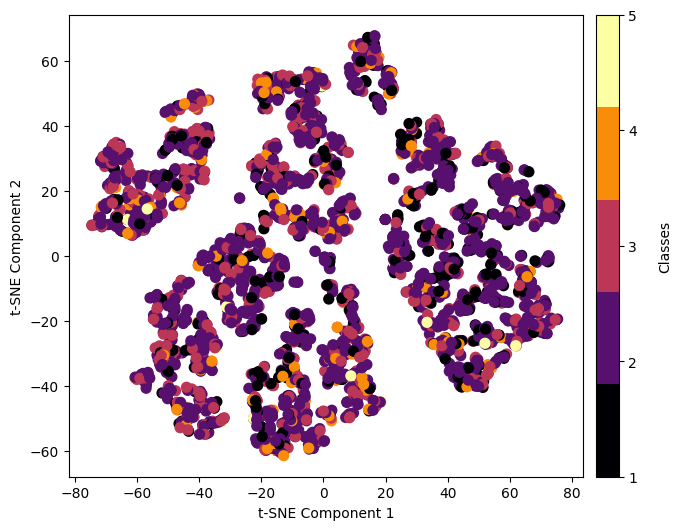

In [8]:
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X_embedded = tsne.fit_transform(dataset_scaled)

df_tsne = pd.DataFrame(data=X_embedded, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = label

colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=cmap, s=50)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

cb = plt.colorbar(ticks=np.unique(label), pad=0.02)
cb.set_ticklabels(np.unique(label).astype(str)) 
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

plt.show()

Собственная реализация

In [9]:
def compute_distances(X):
    sum_X = np.sum(X**2, axis=1).reshape(-1, 1)  # Сумма квадратов каждого вектора
    distances = sum_X + sum_X.T - 2 * np.dot(X, X.T)  # Евклидово расстояние (квадрат)
    distances[distances < 0] = 0  # Избавляемся от отрицательных чисел из-за численной погрешности
    
    distances = np.sqrt(distances)
    
    distances /= np.max(distances)  # Нормализация
    
    distances += 1e-8  # Защита от деления на ноль или переполнения
    
    return distances

def compute_pairwise_affinities(X, perplexity=30, tol=1e-5):
    """Вычисляет вероятности P_ij в высокоразмерном пространстве."""
    n = X.shape[0]
    distances = compute_distances(X)
    sigmas = np.ones(n)
    
    P = np.zeros((n, n))
    log_perplexity = np.log(perplexity)
    
    for i in range(n):
        beta_min, beta_max = None, None
        beta = 1.0
        for _ in range(50):
            # Числовая стабильность для экспоненты
            p_i_unnormalized = np.exp(-distances[i] * beta - np.max(-distances[i] * beta))
            p_i_unnormalized[i] = 0  # Исключаем саму точку
            
            sum_p_i = np.sum(p_i_unnormalized)
            
            if sum_p_i == 0:
                sum_p_i += 1e-8  # Избегаем деления на ноль
            
            p_i = p_i_unnormalized / sum_p_i
            h_i = np.log(sum_p_i) + beta * np.sum(distances[i] * p_i) / sum_p_i  # Энтропия
            
            # Сравнение с требуемой энтропией
            diff = h_i - log_perplexity
            if np.abs(diff) < tol:
                break
            if diff > 0:
                beta_min = beta
                beta = beta * 2 if beta_max is None else (beta + beta_max) / 2
            else:
                beta_max = beta
                beta = beta / 2 if beta_min is None else (beta + beta_min) / 2
        P[i] = p_i
    
    P = (P + P.T) / (2 * n)  # Симметризация
    return P

def compute_low_dim_affinities(Y):
    """Вычисляет вероятности Q_ij в низкоразмерном пространстве."""
    distances = np.sum(Y**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(Y, Y.T)
    distances[distances < 0] = 0  # Числовая стабильность
    inv_distances = 1 / (1 + distances)
    np.fill_diagonal(inv_distances, 0)
    Q = inv_distances / np.sum(inv_distances)
    return Q

def gradient_descent(P, labels, Y = [], n_iter=1000, learning_rate=200, n_components=2, log = True):
    n = P.shape[0]
    if len(Y) == 0:
        Y = np.random.normal(0, 0.01, (n, n_components))  # Инициализация

    kl_prev = 10
    kl = 1
    iter = 0
    while (((kl_prev - kl) > 0.007) | (iter < 100)) & (iter < 500): 
        Q = compute_low_dim_affinities(Y)
        PQ_diff = P - Q
        grad = np.zeros_like(Y)
        
        for i in range(n):
            grad[i] = 4 * np.sum((PQ_diff[i, :, None] * (Y[i] - Y)), axis=0)
        
        Y -= learning_rate * grad

        kl_prev = kl
        kl = np.sum(P * np.log((P + 1e-8) / (Q + 1e-8)))
        iter = iter + 1
        if log:
            print(f"Iteration {iter}: KL Divergence = {kl:.4f}")
    return Y


In [10]:
np.random.seed(44)
perplexity = 60
n_iter=200
learning_rate=100
n_components=2

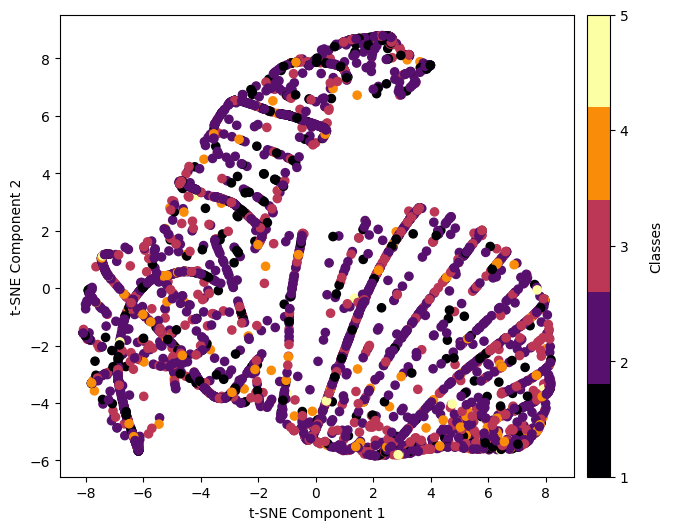

In [12]:
P2 = compute_pairwise_affinities(dataset.to_numpy(), perplexity=perplexity)
Y2 = gradient_descent(P2, label, n_iter=n_iter, learning_rate=learning_rate, n_components=n_components, log=False)

df_tsne = pd.DataFrame(data=Y2, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = label

colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=cmap, s=35)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

cb = plt.colorbar(ticks=np.unique(label), pad=0.02)
cb.set_ticklabels(np.unique(label).astype(str)) 
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

plt.show()

# UMAP

Реализация из библиотеки

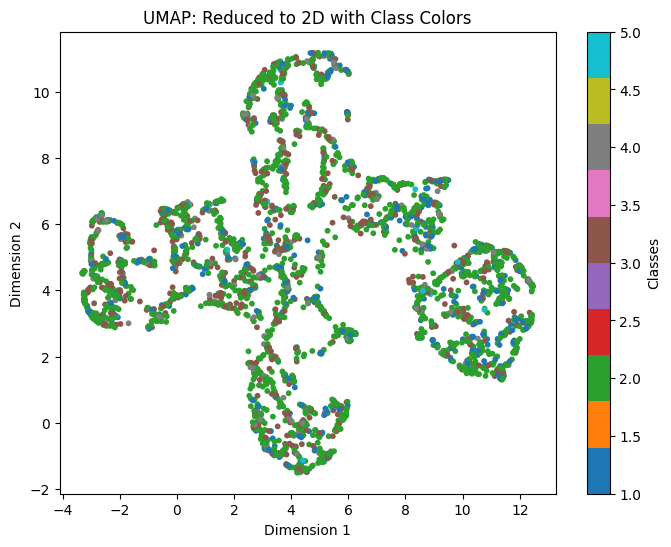

In [18]:
umap_model = umap.UMAP(n_neighbors=40, min_dist=0.05, n_components=2, metric = "correlation")
X_umap = umap_model.fit_transform(dataset_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=label, cmap='tab10', s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Classes')
plt.title("UMAP: Reduced to 2D with Class Colors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Собственная реализация

In [19]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

def umap(X, n_neighbors=15, min_dist=0.1, n_components=2, n_epochs=200, learning_rate=1.0, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]

    #  Ближайшие соседи
    neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = neighbors.kneighbors(X)
    
    sigmas = np.zeros(n_samples)
    p_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        beta = 1.0
        dist_i = distances[i][1:]  # Расстояния до соседей
        log_probs = -dist_i * beta
        probs = np.exp(log_probs - log_probs.max())  # Нормализация
        p_i = probs / probs.sum()
        sigmas[i] = 1 / beta  # Масштаб для точки
        p_matrix[i, indices[i][1:]] = p_i  # Запись вероятностей в P

    p_matrix = (p_matrix + p_matrix.T) / 2  # симметрия
    p_matrix /= p_matrix.sum()  # нормализация

    # инициализация
    embedding = np.random.normal(0, 1, size=(n_samples, n_components))

    for epoch in range(n_epochs):
        grad = np.zeros_like(embedding)

        dist_low_dim = squareform(pdist(embedding, metric="euclidean"))
        dist_low_dim[dist_low_dim == 0] = 1e-6
        
        q_matrix = 1 / (1 + dist_low_dim**2)
        q_matrix[range(n_samples), range(n_samples)] = 0
        q_matrix /= q_matrix.sum()

        for i in range(n_samples):
            diff = embedding[i] - embedding
            attractive_force = np.sum((p_matrix[i, :, None] - q_matrix[i, :, None]) * diff / (1 + dist_low_dim[i, :, None]**2), axis=0)
            
            # Штраф за точки, слишком близко друг к другу
            penalty = np.maximum(0, min_dist - dist_low_dim[i])
            repulsive_force = np.sum((penalty[:, None] * diff), axis=0)
            
            grad[i] = attractive_force - repulsive_force

        embedding += learning_rate * grad

    return embedding

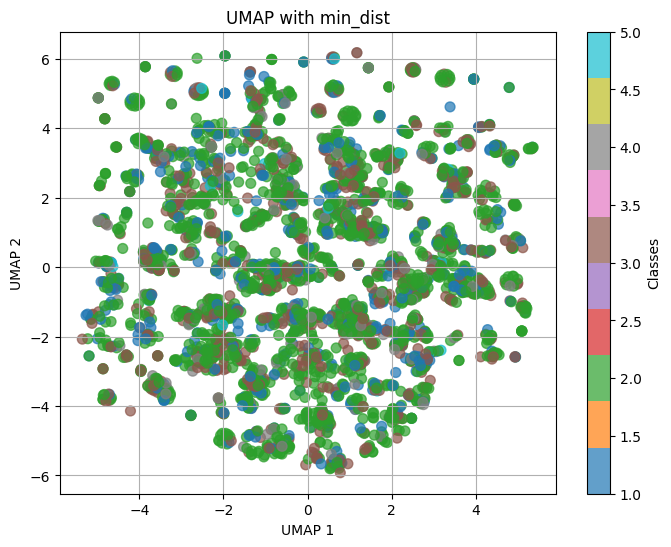

In [20]:
embedding = umap(dataset.to_numpy(), n_neighbors=100, min_dist=0.4, n_epochs=500)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=label, cmap='tab10', s=50, alpha=0.7)
plt.colorbar(label="Classes")
plt.title("UMAP with min_dist")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid()
plt.show()

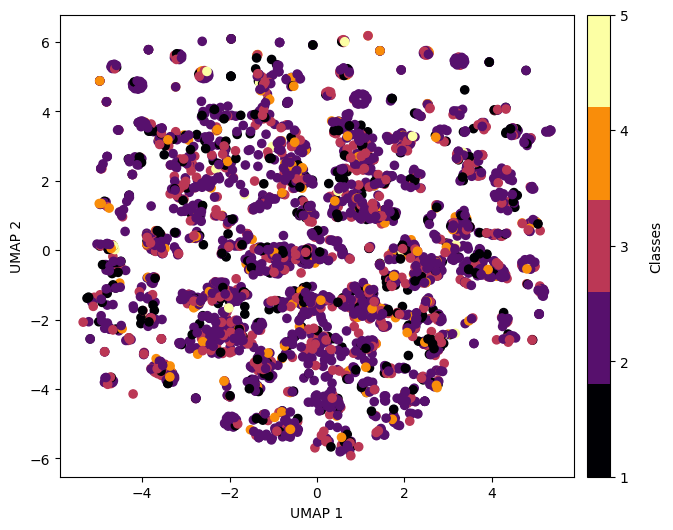

In [21]:
embedding = umap(dataset.to_numpy(), n_neighbors=100, min_dist=0.4, n_epochs=500)

df_umap = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = label

colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

plt.figure(figsize=(8, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['Label'], cmap=cmap, s=35)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

cb = plt.colorbar(ticks=np.unique(label), pad=0.02)
cb.set_ticklabels(np.unique(label).astype(str)) 
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

plt.show()

# Факторный анализ

Реализация из библиотеки

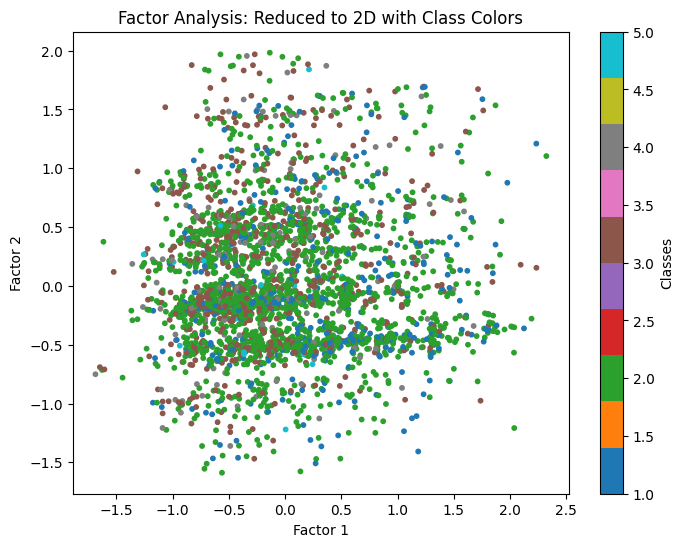

In [22]:
from sklearn.decomposition import FactorAnalysis

factor_analysis = FactorAnalysis(n_components=2, random_state=42)
X_fa = factor_analysis.fit_transform(dataset_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_fa[:, 0], X_fa[:, 1], c=label, cmap='tab10', s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Classes')
plt.title("Factor Analysis: Reduced to 2D with Class Colors")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.show()


Собственная реализация

In [23]:
def factor_analysis_simplified(X, labels, n_components=2):
    
    covariance_matrix = np.cov(X.T)
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    principal_components = eigenvectors[:, :n_components]
    
    X_fa = np.dot(X, principal_components)
    
    return X_fa

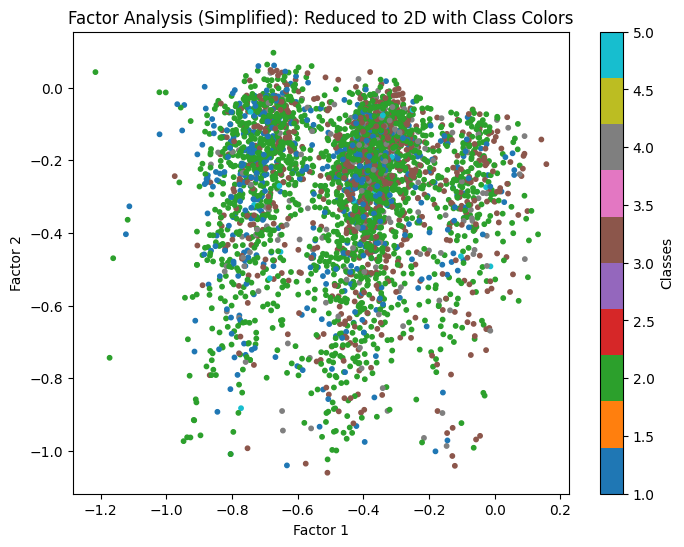

In [24]:
X_fa_custom = factor_analysis_simplified(dataset_scaled, label, n_components=2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_fa_custom[:, 0], X_fa_custom[:, 1], c=label, cmap='tab10', s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Classes')
plt.title("Factor Analysis (Simplified): Reduced to 2D with Class Colors")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.show()

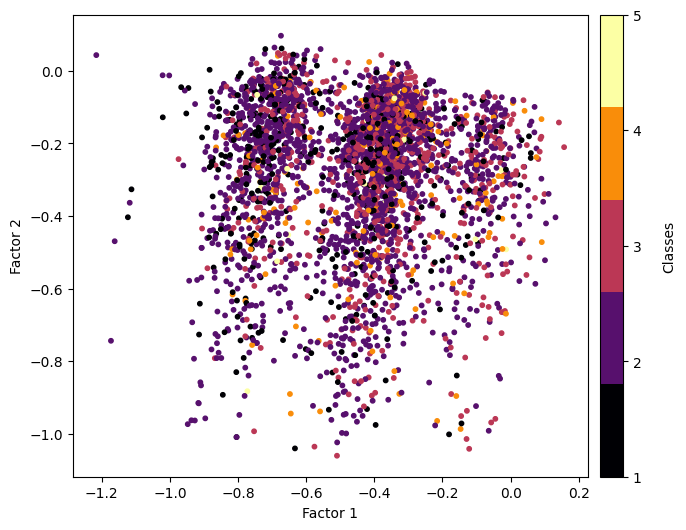

In [25]:
X_fa_custom = factor_analysis_simplified(dataset_scaled, label, n_components=2)

df_umap = pd.DataFrame(data=X_fa_custom, columns=['factor 1', 'factor 2'])
df_umap['Label'] = label

colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

plt.figure(figsize=(8, 6))
plt.scatter(df_umap['factor 1'], df_umap['factor 2'], c=df_umap['Label'], cmap=cmap, s=10)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

cb = plt.colorbar(ticks=np.unique(label), pad=0.02)
cb.set_ticklabels(np.unique(label).astype(str)) 
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

plt.show()

# Кластерный анализ

Реализация из библиотеки

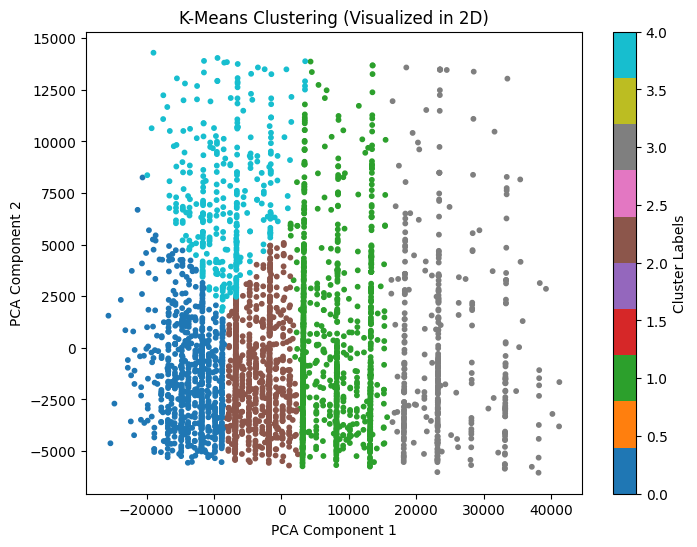

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(dataset)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(dataset)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.colorbar(scatter, label='Cluster Labels')
plt.title("K-Means Clustering (Visualized in 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Собственная реализация

In [27]:
def kmeans_custom(X, n_clusters=5, max_iter=300, tol=1e-4):
    initial_indices = np.random.choice(X.shape[0], n_clusters, replace=False)
    centroids = X[initial_indices]
    
    for iteration in range(max_iter):
        # Вычисление расстояний от точек до центроидов
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        
        # Присвоение точек к ближайшему кластеру
        cluster_labels = np.argmin(distances, axis=1)
        
        # Обновление центроидов
        new_centroids = np.array([X[cluster_labels == k].mean(axis=0) for k in range(n_clusters)])
        
        # Проверка сходимости
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return cluster_labels, centroids

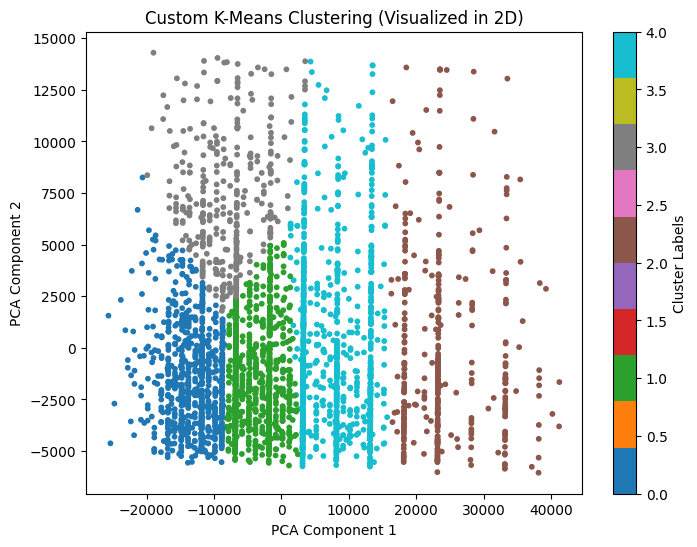

In [28]:
cluster_labels_custom, centroids_custom = kmeans_custom(dataset.to_numpy(), n_clusters=5)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(dataset.to_numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels_custom, cmap='tab10', s=10)
plt.colorbar(scatter, label='Cluster Labels')
plt.title("Custom K-Means Clustering (Visualized in 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

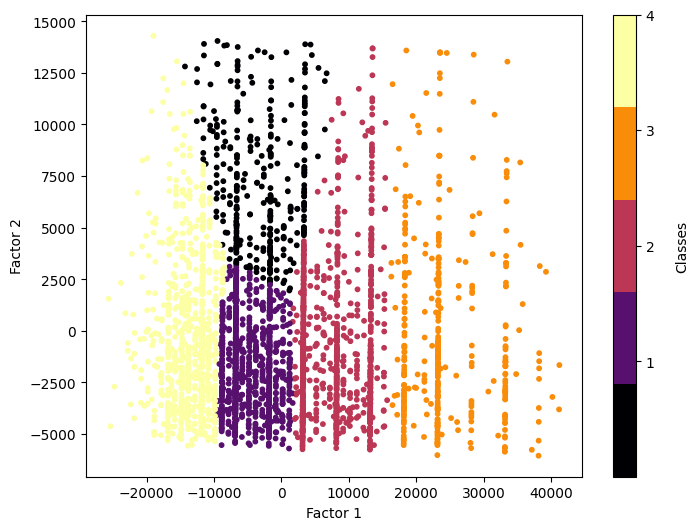

In [29]:
cluster_labels_custom, centroids_custom = kmeans_custom(dataset.to_numpy(), n_clusters=5)

# Применение PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(dataset.to_numpy())

# Создание DataFrame
df_umap = pd.DataFrame(data=X_2d, columns=['factor 1', 'factor 2'])
df_umap['Label'] = cluster_labels_custom

# Создание цветовой карты
colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(df_umap['factor 1'], df_umap['factor 2'], c=df_umap['Label'], cmap=cmap, s=10)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

# Добавление color bar
cb = plt.colorbar(ticks=[1, 2, 3, 4, 5])
#cb.set_ticklabels(['1', '2', '3', '4', '5'])
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

# Сохранение графика
plt.savefig('sdsddsdswewdsff.png', dpi=300)
plt.show()

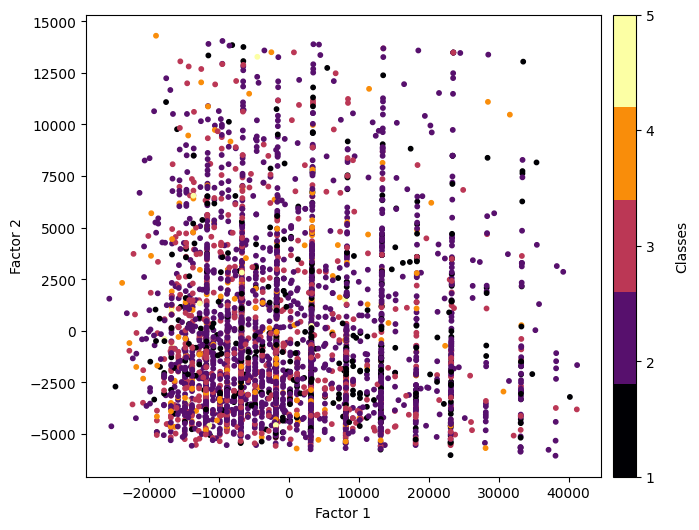

In [30]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(dataset.to_numpy())

# Создаем DataFrame
df_umap = pd.DataFrame(data=X_2d, columns=['factor 1', 'factor 2'])
df_umap['Label'] = label

# Создаем цветовую карту
colors = plt.get_cmap('inferno')(np.linspace(0, 1, 256))
cmap = LinearSegmentedColormap.from_list('CustomInferno', colors, N=5)

# Строим график
plt.figure(figsize=(8, 6))
plt.scatter(df_umap['factor 1'], df_umap['factor 2'], c=df_umap['Label'], cmap=cmap, vmin=1, vmax=5, s=10)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

# Добавляем colorbar
cb = plt.colorbar(ticks=[1, 2, 3, 4, 5], pad=0.02)
cb.set_ticklabels(['1', '2', '3', '4', '5']) 
cb.ax.set_ylabel('Classes', rotation=90, labelpad=15)

# Сохраняем график
plt.show()